In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import networkx as nx
import re


In [3]:
comments_df_2021_08 = pd.read_csv('data/comments/comments_2021-08.csv')  
comments_df_2021_09 = pd.read_csv('data/comments/comments_2021-09.csv')
submissions_df_2021_08 = pd.read_csv('data/submissions/RS_2021-08.csv')  
submissions_df_2021_09 = pd.read_csv('data/submissions/RS_2021-09.csv')

comments_df = pd.concat([comments_df_2021_08, comments_df_2021_09], ignore_index=True)
submissions_df = pd.concat([submissions_df_2021_08, submissions_df_2021_09], ignore_index=True)

subreddits = ['austin', 'texas', 'nyc', 'neworleans', 'louisiana']

print('Comments:', comments_df.shape)
print('Submissions:', submissions_df.shape)

Comments: (914904, 9)
Submissions: (43925, 9)


In [4]:
comments_df = comments_df[comments_df['subreddit'].str.lower().isin(subreddits)]
submissions_df = submissions_df[submissions_df['subreddit'].str.lower().isin(subreddits)]
print('Comments:', comments_df.shape)
print('Submissions:', submissions_df.shape)

Comments: (544974, 9)
Submissions: (21321, 9)


In [5]:
print('Comments dataframe columns: \n', comments_df.columns.to_list())
print('Submissions dataframe columns: \n', submissions_df.columns.to_list())

Comments dataframe columns: 
 ['id', 'author', 'body', 'link_id', 'parent_id', 'subreddit', 'subreddit_id', 'name', 'created_utc']
Submissions dataframe columns: 
 ['id', 'author', 'title', 'subreddit', 'created_utc', 'url', 'num_comments', 'score', 'selftext']


In [6]:
comments_df.head()

,id,author,body,link_id,parent_id,subreddit,subreddit_id,name,created_utc
0,h79b5rr,diegojones4,What parts of the constitution are getting ame...,t3_ov6e5p,t3_ov6e5p,texas,t5_2qho4,t1_h79b5rr,1627776004
6,h79b8hy,KGBcommunist,"you are a fascist and you dont even know it. ""...",t3_ouv0f6,t1_h78nl15,nyc,t5_2qhu2,t1_h79b8hy,1627776043
7,h79b9dv,TheBlueRajasSpork,Do you not realize how pathetic you sound? Do ...,t3_oumy2f,t1_h797a0f,nyc,t5_2qhu2,t1_h79b9dv,1627776056
8,h79b9iq,ms_bee27,Oh god. My district is actually great about te...,t3_ov8205,t1_h77nw0q,NewOrleans,t5_2qhp5,t1_h79b9iq,1627776058
9,h79b9qz,RobinCradles,I spend half my day terrifying the dog with my...,t3_oum17b,t3_oum17b,NewOrleans,t5_2qhp5,t1_h79b9qz,1627776061


In [7]:
submissions_df.head()

,id,author,title,subreddit,created_utc,url,num_comments,score,selftext
5,ovi0mp,5_Frog_Margin,"McSorley's Ale House, 1940's (?)",nyc,1627776578,https://i.redd.it/8p8z6p4c1ne71.jpg,21,278,NaN
6,ovi0tu,[deleted],[deleted by user],texas,1627776600,https://www.reddit.com/r/texas/comments/ovi0tu...,1,1,[removed]
14,ovi94e,neutralgroundside,Anyone else get goosebumps and cry like a baby...,NewOrleans,1627777503,https://youtu.be/U4LZ_DQwXLA?t=4m16s,15,27,NaN
15,oviahq,tacos4eva,Local yokel back in town. Join me for a Barton...,Austin,1627777660,https://www.reddit.com/r/Austin/comments/oviah...,0,0,[removed]
18,ovif2a,yesyesyesyes01,This poster I saw in a bathroom is infuriating,nyc,1627778172,https://i.redd.it/rvsbb53o6ne71.jpg,31,130,NaN


In [8]:
comments_df['link_id'] = comments_df['link_id'].str.replace('t3_', '')
merged_data = pd.merge(comments_df, submissions_df, left_on='link_id', right_on='id', suffixes=('_comment', '_submission'))

data = merged_data.copy(deep=True)

print(data.columns.to_list())

['id_comment', 'author_comment', 'body', 'link_id', 'parent_id', 'subreddit_comment', 'subreddit_id', 'name', 'created_utc_comment', 'id_submission', 'author_submission', 'title', 'subreddit_submission', 'created_utc_submission', 'url', 'num_comments', 'score', 'selftext']


In [9]:
data.head(1000).to_csv('data/merged_data.csv', index=False)

##### How much are people commenting on power-related threads as compared to non power-related threads?

In [10]:
power_terms = [
    "Blackout", "power", "power grid", "power outage", "power out", "electricity", 
    "electric", "brownout", "voltage", "transformer", "circuit breaker", 
    "electrical outage", "energy storage", "transmission line", "renewable energy", 
    "smart grid", "energy efficiency", "peak demand", "alternative energy", 
    "solar power", "wind energy", "hydropower", "generator", "backup generator", 
    "utilities", "electric utility", "grid", "grid stability", "surge protector", 
    "energy", "microgrid", "off-grid", "rolling blackout", "energy policy", "grid operator", "electric current", "power grid", "power plant", "breaker", "current",
    "distribution", "substation", "energy grid", "load shedding", "frequency regulation", "demand response", "battery storage", "turbine", 
    "nuclear energy", "fossil fuels", "bioenergy", "geothermal", "load center", "interconnector", "distributed generation", "demand-side management", 
    "capacity factor", "net metering", "kilowatt-hour", "megawatt", "outage", "grid failure", "electrical fault", "cable fault", "energy consumption", 
    "load balancing", "grid expansion", "power line", "overload", "switchgear", "resilience", "reliability", "power factor", "feed-in tariff", 
    "baseline load", "peaker plant", "inverter", "grid-tied", "islanding", "energy mix"
]
pattern = '|'.join(power_terms).lower()

In [11]:
hurricane_terms = [
    'Ida', 'Hurricane', 'Catastrophe', 'Landfall', 'Flooding', 'Wind', 
    'Destruction', 'Storm', 'Evacuation', 'Resilience', 'Recovery', 'Intensity', 
    'Powerless', 'Rainfall', 'Surge', 'Emergency', 'Damage', 'Aftermath', 'Climate', 
    'Rescues', 'Gulf', 'Coastal', 'Relief', 'Saffir-Simpson', 
    'Carribean', 'Preparedness', 'Infrastructure', 'Category4', 'Windspeed', 'Response', 
    'Federal', 'Agencies', 'Vulnerable', 'Communities', 'Alert', 'Disaster', 'Path', 
    'Impact', '2021', 'Devastation', 'Restoration', 'Weather', 
    'Warning', 'Tropics', 'Hurricane', 'Storm', 'Winds', 'Tornado', 'Damage', 'Guts', 
    'Disaster', 'Flood', 'Waters', 'Floodwaters', 'Outbreak', 'Rainfall', 'Rain', 'Cyclone', 
    'Typhoon', 'Twister', 'Devastation', 'Deluge', 'Surge', 'Torrent', 'Cataclysm', 'Tempest', 
    'Gust', 'Whirlwind', 'Ruin', 'Courage', 'Calamity', 'Inundation', 'Stream', 'Overflow', 
    'Epidemic', 'Drizzle', 'Precipitation', 'Monsoon', 'Squall', 'Vortex', 'Havoc', 'Bravery', 
    'Tragedy', 'Submersion', 'Currents', 'Swell', 'Showers', 'Moisture', 'Downpour', 
    'Gales', 'Funnel', 'Wreckage', 'Resilience'
]

hurricane_pattern = '|'.join(hurricane_terms).lower()

In [12]:
# Function to categorize a row as power-related or not.
# Columns to consider: title, selftext, and body
def is_power_related(row):
    title = row['title'] if isinstance(row['title'], str) else ''
    selftext = row['selftext'] if isinstance(row['selftext'], str) else ''
    body = row['body'] if isinstance(row['body'], str) else ''
    return bool(re.search(pattern, title.lower())) or \
           bool(re.search(pattern, selftext.lower())) or \
           bool(re.search(pattern, body.lower()))


data['is_power_related'] = data.apply(is_power_related, axis=1)

    

In [13]:
def is_hurricane_related(row):
    title = row['title'] if isinstance(row['title'], str) else ''
    selftext = row['selftext'] if isinstance(row['selftext'], str) else ''
    body = row['body'] if isinstance(row['body'], str) else ''
    return bool(re.search(hurricane_pattern, title.lower())) or \
           bool(re.search(hurricane_pattern, selftext.lower())) or \
           bool(re.search(hurricane_pattern, body.lower()))

data['is_hurricane_related'] = data.apply(is_hurricane_related, axis=1)

In [14]:
data.head(1000).to_csv('data/merged_data.csv', index=False)

In [15]:
data.shape

(540091, 20)

In [16]:
record_count_power_related = data['is_power_related'].value_counts()
print("Power-Related Comments:", record_count_power_related.get(True, 0))
print("Non Power-Related Comments:", record_count_power_related.get(False, 0))


Power-Related Comments: 56524
Non Power-Related Comments: 483567


In [17]:
record_count_hurricane_related = data['is_hurricane_related'].value_counts()
print("Hurricane-Related Comments:", record_count_hurricane_related.get(True, 0))
print("Non Hurricane-Related Comments:", record_count_hurricane_related.get(False, 0))

Hurricane-Related Comments: 149278
Non Hurricane-Related Comments: 390813


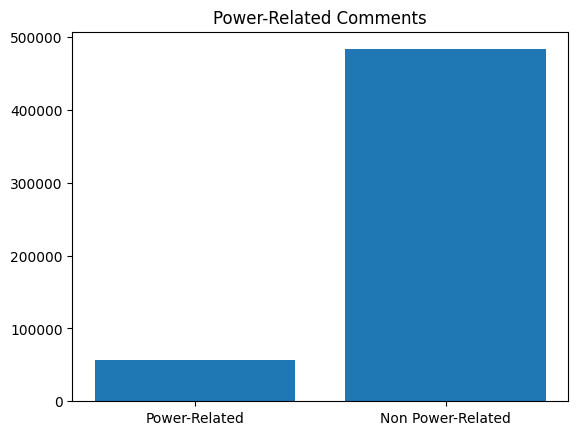

In [18]:
plt.bar(['Power-Related', 'Non Power-Related'], [record_count_power_related.get(True, 0), record_count_power_related.get(False, 0)])
plt.title('Power-Related Comments')
plt.show()

In [25]:
thread_power_related = data.groupby('link_id')['is_power_related'].any()
power_related_threads = thread_power_related.sum()

non_power_related_threads = len(thread_power_related) - power_related_threads
print("Power-Related Threads:", power_related_threads)
print("Non Power-Related Threads:", non_power_related_threads)
print("Total Threads:", len(thread_power_related))

Power-Related Threads: 4896
Non Power-Related Threads: 10931
Total Threads: 15827


In [22]:
threads_per_subreddit = data.groupby('subreddit_submission')['link_id'].nunique()
print(type(threads_per_subreddit))

subreddit_submission
Austin        4663
Louisiana      477
NewOrleans    5005
nyc           3386
texas         2296
Name: link_id, dtype: int64


##### Now, lets look at the number of threar for each subreddit

In [64]:
fig = px.bar(threads_per_subreddit, x=threads_per_subreddit.index, y='link_id', 
             title='Number of threads , per Subreddit ',
             labels={'link_id': 'Number of Threads', 'index': 'Subreddit', 'subreddit_submission': 'Subreddit'},
             color=threads_per_subreddit.index,
             color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

##### Top n largest power related threads

In [51]:
n = 10
power_related_data = data[data['is_power_related']]
thread_comment_counts = power_related_data.groupby('link_id').size().sort_values(ascending=False)

top_n_threads_ids = thread_comment_counts.head(n).index

top_n_threads_info = submissions_df[submissions_df['id'].isin(top_n_threads_ids)][['title', 'url', 'subreddit']]

print('Top {} largest threads discussing power:'.format(n))
top_n_threads_info.head(n)


Top 10 largest threads discussing power:


,title,url,subreddit
7294,Dear fellow Texans. Please get vaccinated. Do ...,https://www.reddit.com/r/texas/comments/p2rkmz...,texas
17639,"""'Ida' want it"" - A John Sneaux Story"" - Hurri...",https://www.reddit.com/r/NewOrleans/comments/p...,NewOrleans
17834,LTISD School board meeting last night on masks...,https://www.reddit.com/r/Austin/comments/pcly3...,Austin
18591,Who is staying?,https://www.reddit.com/r/NewOrleans/comments/p...,NewOrleans
20126,Megathread: Post Hurricane Ida Discussion &amp...,https://www.reddit.com/r/NewOrleans/comments/p...,NewOrleans
21901,Who else can't wait for Abbott to leave?,https://www.reddit.com/r/texas/comments/pfh38m...,texas
23150,"Hurricane Ida - Post Storm ""I have power!"" Meg...",https://www.reddit.com/r/NewOrleans/comments/p...,NewOrleans
26704,For those that are in favor of the new anti-ab...,https://www.reddit.com/r/texas/comments/pigku5...,texas
27493,So when are they going to fix our Electric Grid?,https://www.reddit.com/r/texas/comments/pj5s9b...,texas
27738,"Kind of curious about this now, how do ya'll f...",https://www.reddit.com/r/Austin/comments/pjc5l...,Austin


/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_9249/604797435.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_9249/604797435.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



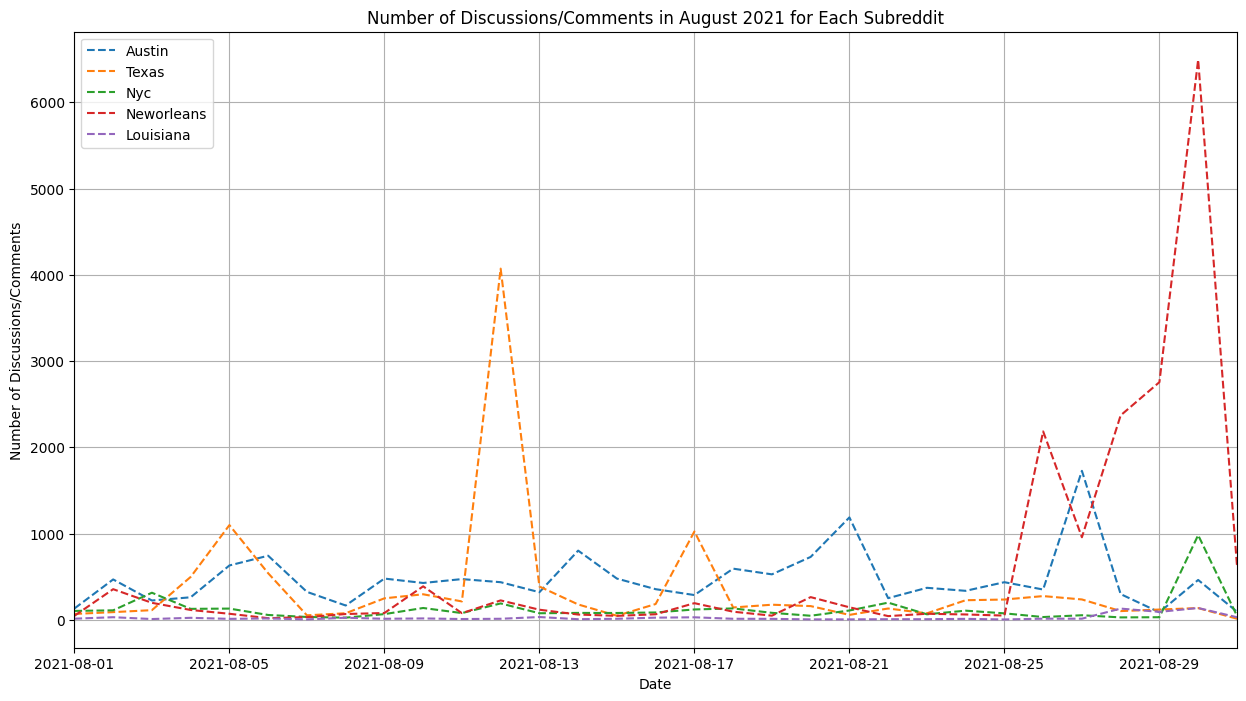

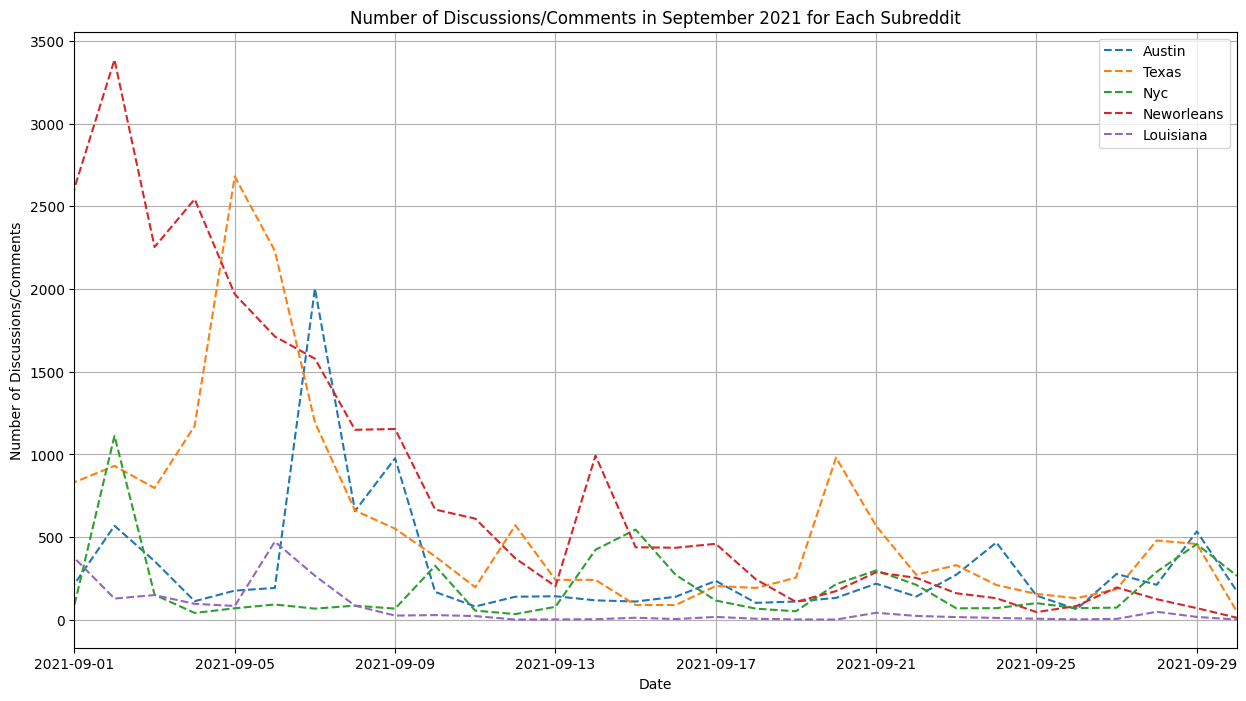

In [62]:
power_related_data = data[data['is_power_related']]

power_related_data['date_comment'] = pd.to_datetime(power_related_data['created_utc_comment'], unit='s')   
power_related_data['date_submission'] = pd.to_datetime(power_related_data['created_utc_submission'], unit='s')

august_range = (pd.Timestamp('2021-08-01'), pd.Timestamp('2021-08-31'))
september_range = (pd.Timestamp('2021-09-01'), pd.Timestamp('2021-09-30'))

def plot_monthly_activity(data, date_range, month_name):
    plt.figure(figsize=(15, 8))

    for subreddit in subreddits:
        subreddit_data = data[data['subreddit_submission'].str.lower() == subreddit.lower()]

        monthly_data = subreddit_data[
            (subreddit_data['date_comment'] >= date_range[0]) & 
            (subreddit_data['date_comment'] <= date_range[1]) |
            (subreddit_data['date_submission'] >= date_range[0]) & 
            (subreddit_data['date_submission'] <= date_range[1])
        ]

        comment_counts = monthly_data.groupby(monthly_data['date_comment'].dt.date).size()
        submission_counts = monthly_data.groupby(monthly_data['date_submission'].dt.date).size()

        combined_counts = comment_counts.add(submission_counts, fill_value=0)

        combined_counts.plot(label=subreddit.title(), linestyle='dashed')

    plt.title(f'Number of Discussions/Comments in {month_name} 2021 for Each Subreddit')
    plt.xlabel('Date')
    plt.ylabel('Number of Discussions/Comments')
    plt.legend()
    plt.xlim(date_range)
    plt.grid(True)
    plt.show()


plot_monthly_activity(power_related_data, august_range, 'August')
plot_monthly_activity(power_related_data, september_range, 'September')



##### Hurricane related threads


In [63]:
thread_hurricane_related = data.groupby('link_id')['is_hurricane_related'].any()
hurricane_related_threads = thread_hurricane_related.sum()
non_hurricane_related_threads = len(thread_hurricane_related) - hurricane_related_threads
print("Hurricane-Related Threads:", hurricane_related_threads)
print("Non Hurricane-Related Threads:", non_hurricane_related_threads)
print("Total Threads:", len(thread_hurricane_related))


Hurricane-Related Threads: 9144
Non Hurricane-Related Threads: 6683
Total Threads: 15827


##### Top n threads discussing hurricane

In [65]:
n = 10  
hurricane_related_data = data[data['is_hurricane_related']]
thread_comment_counts = hurricane_related_data.groupby('link_id').size().sort_values(ascending=False)
top_n_threads_ids = thread_comment_counts.head(n).index
top_n_threads_info = submissions_df[submissions_df['id'].isin(top_n_threads_ids)][['title', 'url', 'subreddit']]
print('Top {} largest threads discussing hurricanes:'.format(n))
top_n_threads_info.head(n)



Top 10 largest threads discussing hurricanes:


,title,url,subreddit
3130,And open letter to antivaxx NYers threatening ...,https://www.reddit.com/r/nyc/comments/oyplm0/a...,nyc
17639,"""'Ida' want it"" - A John Sneaux Story"" - Hurri...",https://www.reddit.com/r/NewOrleans/comments/p...,NewOrleans
19666,Get vaccinated for fucks sake. My surgery is p...,https://www.reddit.com/r/texas/comments/pe2k4s...,texas
20126,Megathread: Post Hurricane Ida Discussion &amp...,https://www.reddit.com/r/NewOrleans/comments/p...,NewOrleans
23150,"Hurricane Ida - Post Storm ""I have power!"" Meg...",https://www.reddit.com/r/NewOrleans/comments/p...,NewOrleans
26021,As the moderator of r/texas it is time for me ...,https://www.reddit.com/r/texas/comments/phwgxh...,texas
26704,For those that are in favor of the new anti-ab...,https://www.reddit.com/r/texas/comments/pigku5...,texas
27493,So when are they going to fix our Electric Grid?,https://www.reddit.com/r/texas/comments/pj5s9b...,texas
28003,"The city of Portland, Oregon, announced it int...",https://nypost.com/2021/09/06/portland-to-cut-...,texas
30539,Texas passes law that bans kicking people off ...,https://www.reddit.com/r/texas/comments/plndyb...,texas


/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_9249/2624500110.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_9249/2624500110.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



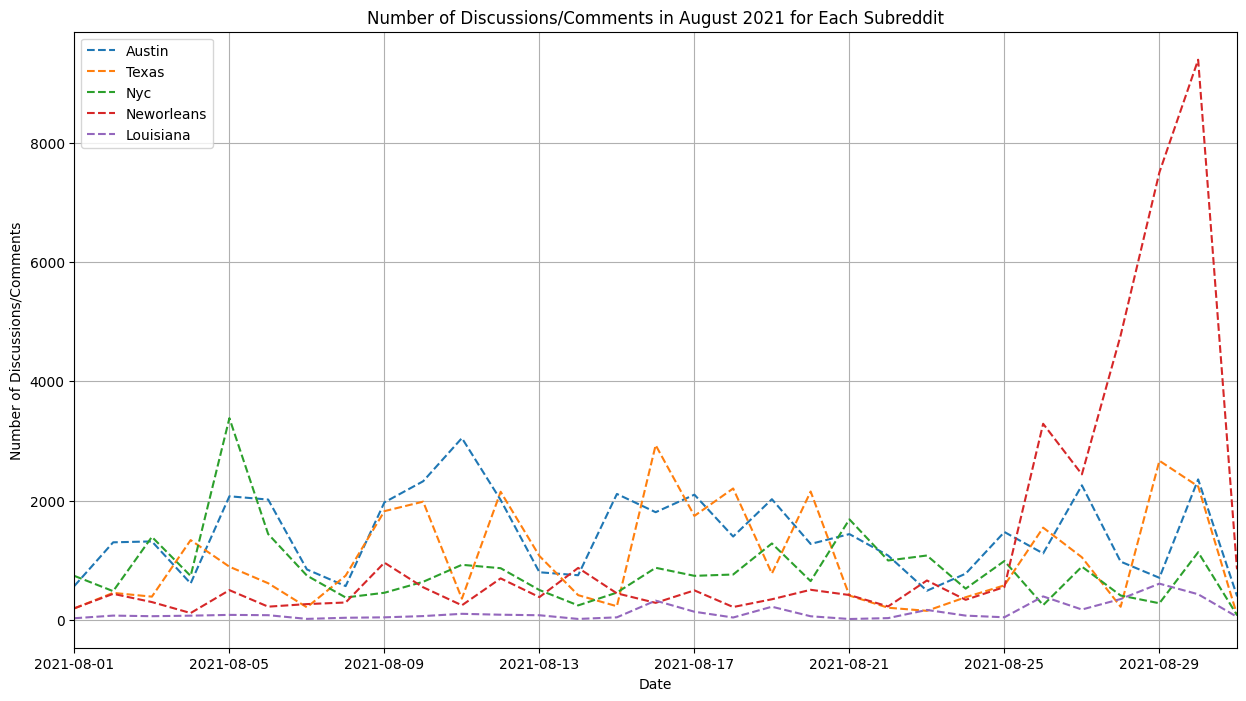

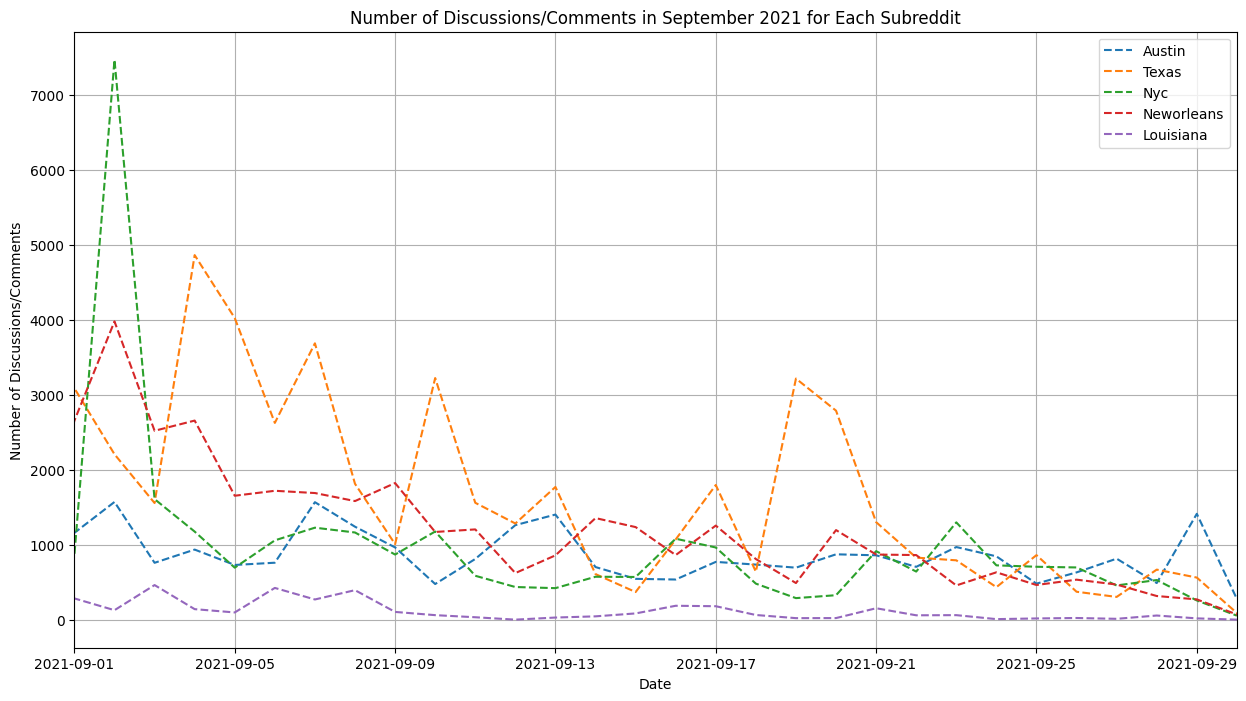

In [66]:
hurricane_related_data['date_comment'] = pd.to_datetime(hurricane_related_data['created_utc_comment'], unit='s')
hurricane_related_data['date_submission'] = pd.to_datetime(hurricane_related_data['created_utc_submission'], unit='s')


plot_monthly_activity(hurricane_related_data, august_range, 'August')
plot_monthly_activity(hurricane_related_data, september_range, 'September')

